In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
from torch.autograd import Variable
train_x = Variable(torch.linspace(0, 1, 11))
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [4]:
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch import ObservationModel
from gpytorch.random_variables import GaussianRandomVariable

In [5]:
class ExactGPObservationModel(gpytorch.ObservationModel):
    def __init__(self):
        mean_module = ConstantMean()
        covar_module = RBFKernel()
        likelihood = GaussianLikelihood()
        
        mean_module.initialize(constant=0)
        covar_module.initialize(log_lengthscale=-3)
        likelihood.initialize(log_noise=math.log(0.09))
        
        super(ExactGPObservationModel,self).__init__(likelihood,
                {'mean_module': mean_module, 'covar_module': covar_module})
        
    
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        latent_pred = GaussianRandomVariable(mean_x, covar_x)
        observed_pred = self.observation_model(latent_pred)
        return observed_pred

prior_observation_model = ExactGPObservationModel()

In [6]:
def plot_model_and_predictions(observation_model):
    f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
    
    test_x = Variable(torch.linspace(0, 1, 51))
    
    observed_pred = observation_model(test_x)

    def ax_plot(ax, rand_var, title):
        lower, upper = rand_var.confidence_region()
        ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
        ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
        ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])
        ax.set_title(title)
    
    ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')
    
    return f

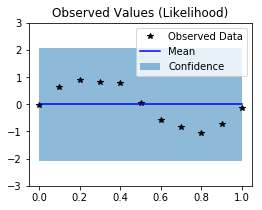

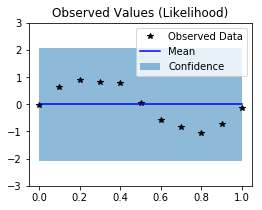

In [7]:
plot_model_and_predictions(prior_observation_model)

In [8]:
from gpytorch.inference import ExactGPInference

def log_function(loss, optimizer, observation_model):
    return 'Iter: %02d, Loss: %.3f' % (optimizer.n_iter, loss.data[0])

infer = ExactGPInference(prior_observation_model)
posterior_observation_model = infer.run(train_x, train_y, log_function=log_function)

INFO:root:Iter: 01, Loss: 7.291
INFO:root:Iter: 02, Loss: 7.291
INFO:root:Iter: 03, Loss: 12.705
INFO:root:Iter: 04, Loss: 3.650
INFO:root:Iter: 05, Loss: 3.650
INFO:root:Iter: 06, Loss: 3.650
INFO:root:Iter: 07, Loss: 18.282
INFO:root:Iter: 08, Loss: 3.417
INFO:root:Iter: 09, Loss: 3.417
INFO:root:Iter: 10, Loss: 3.417
INFO:root:Iter: 11, Loss: 2.932
INFO:root:Iter: 12, Loss: 2.932
INFO:root:Iter: 13, Loss: 2.932
INFO:root:Iter: 14, Loss: 2.754
INFO:root:Iter: 15, Loss: 2.754
INFO:root:Iter: 16, Loss: 2.754
INFO:root:Iter: 17, Loss: 2.501
INFO:root:Iter: 18, Loss: 2.501
INFO:root:Iter: 19, Loss: 2.501
INFO:root:Iter: 20, Loss: 2.478
INFO:root:Iter: 21, Loss: 2.478
INFO:root:Iter: 22, Loss: 2.478
INFO:root:Iter: 23, Loss: 2.476
INFO:root:Iter: 24, Loss: 2.476
INFO:root:Iter: 25, Loss: 2.476
INFO:root:Iter: 26, Loss: 2.476
INFO:root:Iter: 27, Loss: 2.476
INFO:root:Iter: 28, Loss: 2.476
INFO:root:Iter: 29, Loss: 2.476
INFO:root:Iter: 30, Loss: 2.476
INFO:root:Iter: 31, Loss: 2.476
INFO:r

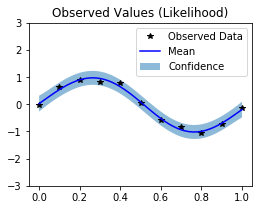

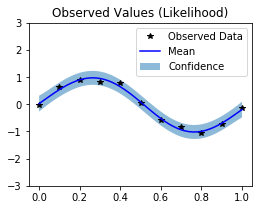

In [9]:
plot_model_and_predictions(posterior_observation_model)